In [2]:
#load all the necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

C:\Users\maria\AppData\Local\Temp\ipykernel_25396\641980835.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
#load the data
song_data = pd.read_csv("spotify_song.csv")
print(song_data.head())

   Unnamed: 0                track_id  \
0           0  6f807x0ima9a1j3VPbc7VN   
1           1  0r7CVbZTWZgbTCYdfa2P31   
2           2  1z1Hg7Vb0AhHDiEmnDE79l   
3           3  75FpbthrwQmzHlBJLuGdC7   
4           4  1e8PAfcKUYoKkxPhrHqw4x   

                                          track_name      track_artist  \
0  I Don't Care (with Justin Bieber) - Loud Luxur...        Ed Sheeran   
1                    Memories - Dillon Francis Remix          Maroon 5   
2                    All the Time - Don Diablo Remix      Zara Larsson   
3                  Call You Mine - Keanu Silva Remix  The Chainsmokers   
4            Someone You Loved - Future Humans Remix     Lewis Capaldi   

   track_popularity          track_album_id  \
0                66  2oCs0DGTsRO98Gh5ZSl2Cx   
1                67  63rPSO264uRjW1X5E6cWv6   
2                70  1HoSmj2eLcsrR0vE9gThr4   
3                60  1nqYsOef1yKKuGOVchbsk6   
4                69  7m7vv9wlQ4i0LFuJiE2zsQ   

                         

In [4]:
song_data.shape

(32833, 24)

In [5]:
#Check for missing values
song_data.isnull().sum()

Unnamed: 0                  0
track_id                    0
track_name                  5
track_artist                5
track_popularity            0
track_album_id              0
track_album_name            5
track_album_release_date    0
playlist_name               0
playlist_id                 0
playlist_genre              0
playlist_subgenre           0
danceability                0
energy                      0
key                         0
loudness                    0
mode                        0
speechiness                 0
acousticness                0
instrumentalness            0
liveness                    0
valence                     0
tempo                       0
duration_ms                 0
dtype: int64

In [6]:
#Drop the missing values
clean_song_data = song_data.dropna()

#check for missing values again
clean_song_data.isnull().sum()

Unnamed: 0                  0
track_id                    0
track_name                  0
track_artist                0
track_popularity            0
track_album_id              0
track_album_name            0
track_album_release_date    0
playlist_name               0
playlist_id                 0
playlist_genre              0
playlist_subgenre           0
danceability                0
energy                      0
key                         0
loudness                    0
mode                        0
speechiness                 0
acousticness                0
instrumentalness            0
liveness                    0
valence                     0
tempo                       0
duration_ms                 0
dtype: int64

In [7]:
#Check for any duplicated items
clean_song_data.duplicated()

#drop any duplicates
clean_song_data.drop_duplicates(inplace=True)

C:\Users\maria\AppData\Local\Temp\ipykernel_25396\1269268935.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_song_data.drop_duplicates(inplace=True)


In [8]:
#drop any columns that we dim irrelevant for the recommendation system
cleaned_song_data = clean_song_data.drop(['Unnamed: 0'], axis=1)

In [9]:
#print the names of the columns
print(cleaned_song_data.columns)

Index(['track_id', 'track_name', 'track_artist', 'track_popularity',
       'track_album_id', 'track_album_name', 'track_album_release_date',
       'playlist_name', 'playlist_id', 'playlist_genre', 'playlist_subgenre',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms'],
      dtype='object')


In [10]:
# Feature selection based on recommended features
features_for_modeling = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
                         'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'mode', 'key']

In [11]:
# Convert 'track_album_release_date' to datetime and extract the year
cleaned_song_data['track_album_release_date'] = pd.to_datetime(cleaned_song_data['track_album_release_date'], errors='coerce', infer_datetime_format=True)
cleaned_song_data['release_year'] = cleaned_song_data['track_album_release_date'].dt.year
features_for_modeling.append('release_year')

C:\Users\maria\AppData\Local\Temp\ipykernel_25396\1182481839.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  cleaned_song_data['track_album_release_date'] = pd.to_datetime(cleaned_song_data['track_album_release_date'], errors='coerce', infer_datetime_format=True)


In [12]:
# Select and normalize features
X = cleaned_song_data[features_for_modeling].fillna(0)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=features_for_modeling)
X_lstm = X.values.reshape((X.shape[0], X.shape[1], 1))  # Reshape for LSTM input

In [13]:
# Create a binary target based on 'track_popularity'
popularity_threshold = cleaned_song_data['track_popularity'].quantile(0.75)
y = (cleaned_song_data['track_popularity'] >= popularity_threshold).astype(int)
y = to_categorical(y)  # Convert labels to categorical one-hot encoding


In [14]:
# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y, test_size=0.2, random_state=42)

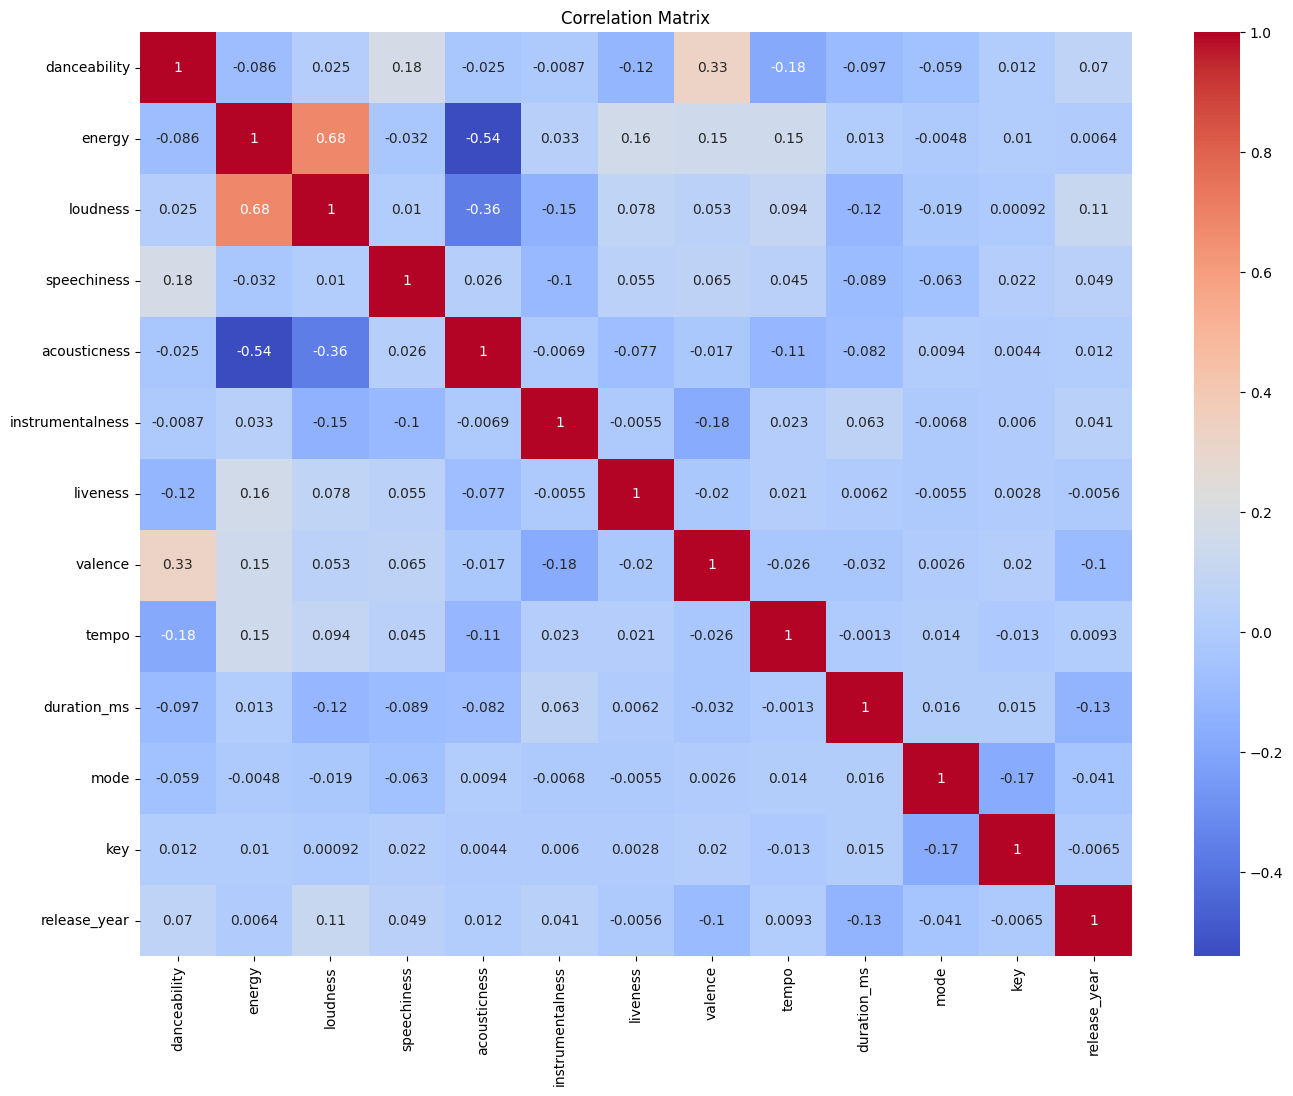

In [15]:
# Created a heatmap to see the correlation between the different features of the data
corr_matrix = X.corr()
plt.figure(figsize=(16,12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [16]:
# Create the LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], 1), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))
optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Making predictions on the testing set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Calculating metrics
accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision = precision_score(y_test_classes, y_pred_classes)
recall = recall_score(y_test_classes, y_pred_classes)
f_score = f1_score(y_test_classes, y_pred_classes)

print(f"Classification Report:\n{classification_report(y_test_classes, y_pred_classes)}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F-Score: {f_score}")

# User interaction for song recommendation
input_song_title = input("Enter the title of a song: ").strip().lower()
input_artist = input("Enter the artist of the song: ").strip().lower()

# Normalize data to lower case for case-insensitive matching
cleaned_song_data['track_name_lower'] = cleaned_song_data['track_name'].str.lower()
cleaned_song_data['track_artist_lower'] = cleaned_song_data['track_artist'].str.lower()

# Find the user's song in the dataset
user_song = cleaned_song_data[(cleaned_song_data['track_name_lower'] == input_song_title) & 
                              (cleaned_song_data['track_artist_lower'] == input_artist)]


if not user_song.empty:
    # Predict the likelihood of liking for the dataset used in model training
    probabilities = model.predict(X_lstm)
    cleaned_song_data['predicted_likelihood'] = probabilities[:, 1]
    
    # Calculate cosine similarity for the user's song
    user_song_features = user_song[features_for_modeling].values.reshape(user_song.shape[0], len(features_for_modeling), 1)
    similarities = cosine_similarity(user_song_features.squeeze(), X_lstm.squeeze()).flatten()

    # Exclude the user's input song from the recommendations
    indices_to_exclude = user_song.index
    probabilities[indices_to_exclude, 1] = -np.inf  # Set probabilities to negative infinity for exclusion

    # Filter and sort the DataFrame based on 'predicted_likelihood'
    sorted_indices = np.argsort(-probabilities[:, 1])  # Indices of songs sorted by decreasing likelihood
    top_similarities_indices = sorted_indices[:20]  # Select top 20 to filter duplicates later

    # Ensure the recommendations are unique and do not include the user's song
    top_recommendations = cleaned_song_data.iloc[top_similarities_indices].drop_duplicates(subset=['track_name', 'track_artist'])
    top_recommendations = top_recommendations.head(10)  # Limit to top 10 after removing duplicates
    top_recommendations['similarity'] = similarities[top_recommendations.index]  # Assign similarities to the top recommendations
    
    # Display the top 10 recommendations
    print("Top 10 recommended songs based on predicted likelihood of being 'liked':")
    print(top_recommendations[['track_name', 'track_artist', 'predicted_likelihood', 'similarity']])
else:
    print("Sorry, the input song is not found in the database.")

Epoch 1/50


c:\Users\maria\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


821/821 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.7353 - loss: 0.5842
Epoch 2/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.7435 - loss: 0.5705
Epoch 3/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.7441 - loss: 0.5696
Epoch 4/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.7420 - loss: 0.5708
Epoch 5/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.7446 - loss: 0.5662
Epoch 6/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.7407 - loss: 0.5658
Epoch 7/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.7424 - loss: 0.5594
Epoch 8/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7398 - loss: 0.5587
Epoch 9/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.7434 - loss: 0.5536
Epoch 10/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.7416 - loss: 0.5555
Epoch 11/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.7389 - loss: 0.5563
Epoch 12/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 14s 